# Data loading

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

npz_path = '/content/drive/MyDrive/container_traces.npz'

def load_np_traces(traces_path):

  data = np.load(traces_path)

  traces=data["traces"]
  labels=data["labels"]

  return traces, labels

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def calculate_snr(traces, labels):
  snr = []
  for t in range(traces.shape[1]):
    print(f"Trace {t} / {traces.shape[1]} ({t/traces.shape[1] * 100}%)")
    class_means = []
    class_vars = []
    for c in range(256):
      # print(f"Class {c} / 256 ({c/256 * 100}%)")
      class_indices = np.where(labels == c)[0]
      if len(class_indices) == 0:
        continue
      samples = traces[class_indices, t]
      class_means.append(np.mean(samples))
      class_vars.append(np.var(samples))
    if len(class_vars) > 0:
      snr_t = np.var(class_means) / np.mean(class_vars)
    else:
      snr_t = 0
    snr.append(snr_t)
  return np.array(snr)

In [ ]:
traces_sim_profiling, labels_sim_profiling = load_np_traces(npz_path)
# traces_sim_profiling = load_np_traces(npz_path)

In [ ]:
print(traces_sim_profiling.shape)
print(labels_sim_profiling.shape)

(5000, 2514)
(1, 5000, 16)


In [ ]:
labels_sim_profiling = labels_sim_profiling.reshape(5000, 16)

In [ ]:
traces_sim_profiling.shape

(5000, 2514)

In [ ]:
snr = calculate_snr(traces_sim_profiling, labels_sim_profiling)

Trace 0 / 2514 (0.0%)
Trace 1 / 2514 (0.03977724741447892%)
Trace 2 / 2514 (0.07955449482895784%)
Trace 3 / 2514 (0.11933174224343676%)
Trace 4 / 2514 (0.15910898965791567%)
Trace 5 / 2514 (0.1988862370723946%)
Trace 6 / 2514 (0.23866348448687352%)
Trace 7 / 2514 (0.27844073190135243%)
Trace 8 / 2514 (0.31821797931583135%)
Trace 9 / 2514 (0.35799522673031026%)
Trace 10 / 2514 (0.3977724741447892%)
Trace 11 / 2514 (0.4375497215592681%)
Trace 12 / 2514 (0.47732696897374705%)
Trace 13 / 2514 (0.5171042163882259%)
Trace 14 / 2514 (0.5568814638027049%)
Trace 15 / 2514 (0.5966587112171837%)
Trace 16 / 2514 (0.6364359586316627%)
Trace 17 / 2514 (0.6762132060461415%)
Trace 18 / 2514 (0.7159904534606205%)
Trace 19 / 2514 (0.7557677008750995%)
Trace 20 / 2514 (0.7955449482895784%)
Trace 21 / 2514 (0.8353221957040573%)
Trace 22 / 2514 (0.8750994431185362%)
Trace 23 / 2514 (0.9148766905330152%)
Trace 24 / 2514 (0.9546539379474941%)
Trace 25 / 2514 (0.994431185361973%)
Trace 26 / 2514 (1.0342084327

KeyboardInterrupt: 

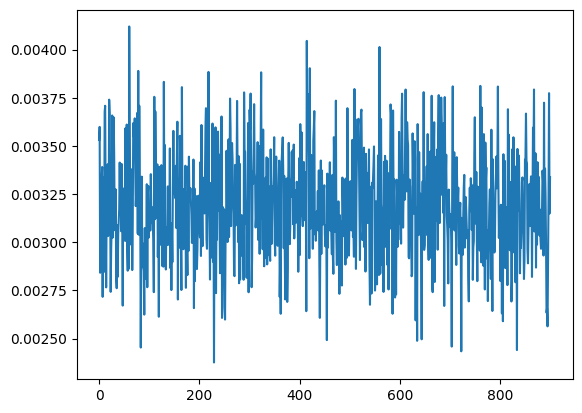

In [ ]:
plt.plot(snr)

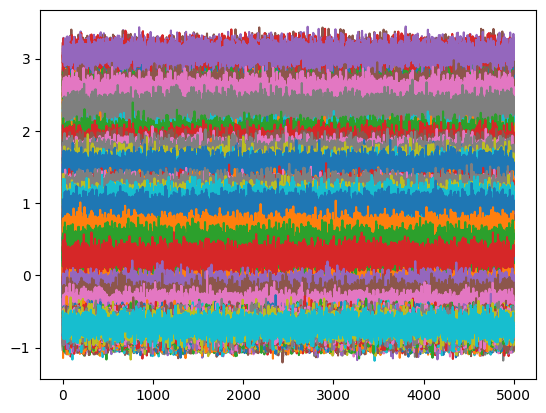

In [ ]:
plt.plot(traces_sim_profiling)

In [ ]:
# try to center the traces
traces_centered = np.array(traces_sim_profiling.shape)

print(traces_centered)

# for trace in traces_sim_profiling:
#   trace -= np.mean(trace)
#   trace /= np.std(trace)

#   traces_centered.append(trace)

[5000 2514]


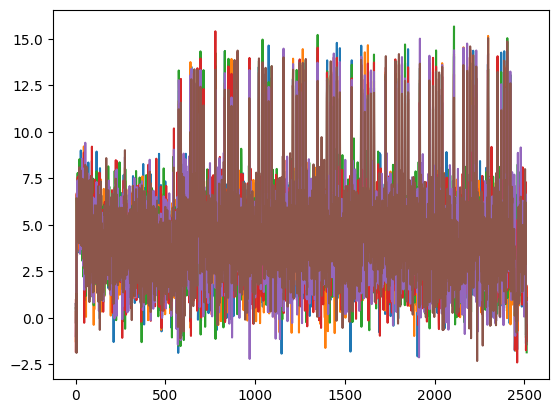

In [ ]:
for i in range(6):
  plt.plot(traces_sim_profiling[i])
plt.show()

Since the baseline noise is gaussian, 'fat' regions of no memory access are seen - not similar to the real world where the noise is more structured. Real traces would have 'thinner' areas outside of leaking points.

In [ ]:
target_labels = labels_sim_profiling

In [ ]:
target_labels

array([[175,  45,   2, ..., 157, 197,  24],
       [216, 196, 208, ...,  45,  43, 219],
       [ 68, 110, 123, ..., 195, 246, 206],
       ...,
       [181,  58,  26, ...,  30,  50, 110],
       [247,  84, 236, ..., 217,  47,  58],
       [ 50, 231,   3, ..., 167, 254,  81]], dtype=uint8)

In [ ]:
test_target = []
for bs in target_labels:
  np_arr = np.frombuffer(bs, dtype=np.uint8)
  test_target.append(np_arr)

len(test_target)

5000

In [ ]:
for t in test_target:
  if t.shape[0] != 16:
    print(f"Wrong shape for {t} ({t.shape[0]})")

In [ ]:
tolerance = 1e-9

for t in var:
  close_to_zero = np.abs(t) < tolerance
  if np.sum(close_to_zero) > 0:
    print("Trace has zeros")

NameError: name 'var' is not defined

In [ ]:
target_labels

array([[167,  44,  54, ..., 242, 167, 210],
       [108, 126, 243, ..., 225,  48,  75],
       [234, 250,  46, ..., 125,   1, 176],
       ...,
       [ 29,  82, 140, ...,  94,  45,   7],
       [132, 254,   1, ..., 221, 233,  23],
       [ 70, 164, 110, ...,  19, 235,  45]], dtype=uint8)

In [ ]:
trace_length = traces_sim_profiling.shape[1]
mean = np.zeros([256, trace_length])
var = np.zeros([256, trace_length])
cpt = np.zeros(256)
i = 0

for trace in traces_sim_profiling:
  mean[target_labels[i]] += trace
  var[target_labels[i]] += np.square(trace)
  cpt[target_labels[i]] += 1
  i += 1

for i in range(256):
  if np.sum(np.abs(var[i]) < tolerance) > 0:
    var[i][np.abs(var[i]) < tolerance] = tolerance
  mean[i] = mean[i] / cpt[i]
  var[i]  = var[i] / cpt[i] - np.square(mean[i])

In [ ]:
varMean = np.var(mean,0)
meanVar = np.mean(var,0)

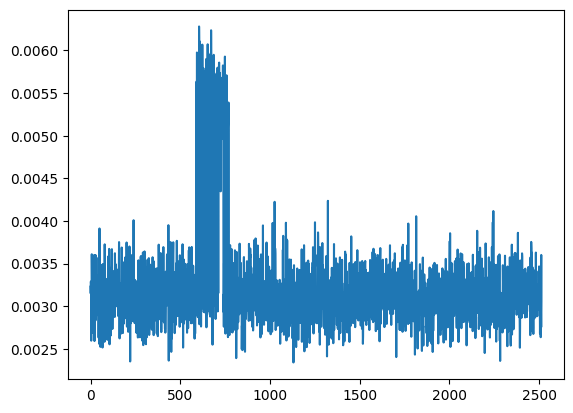

In [ ]:
plt.plot(varMean/meanVar)

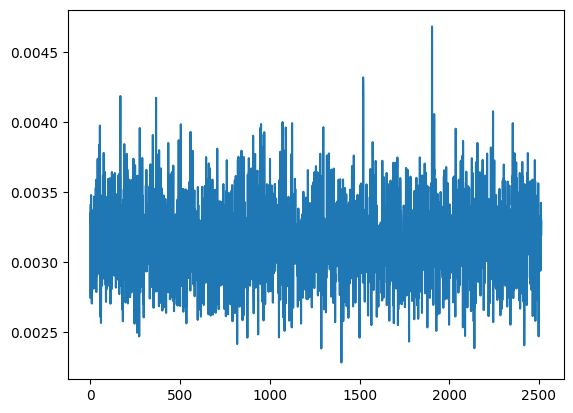

In [ ]:
# 'Desynced' plot
plt.plot(varMean/meanVar)

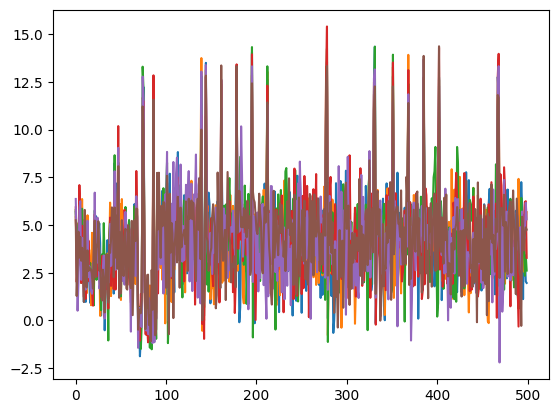

In [ ]:
# zoom in
for i in range(6):
  plt.plot(traces_sim_profiling[i][500:1000])
plt.show()

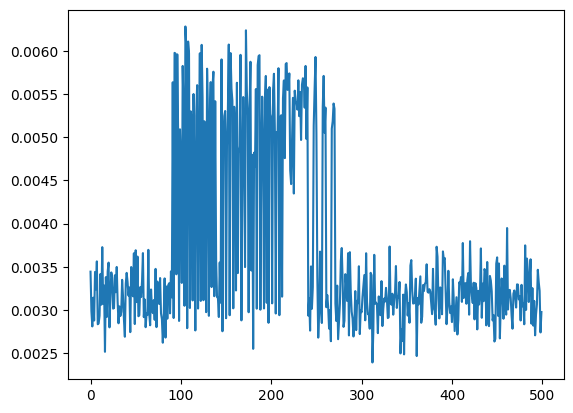

In [ ]:
plt.plot((varMean/meanVar)[500:1000])

# Synced attempt

In [ ]:
npz_path_synced = '/content/drive/MyDrive/container_tracessynced.npz'

traces_sim_profiling, labels_sim_profiling = load_np_traces(npz_path_synced)

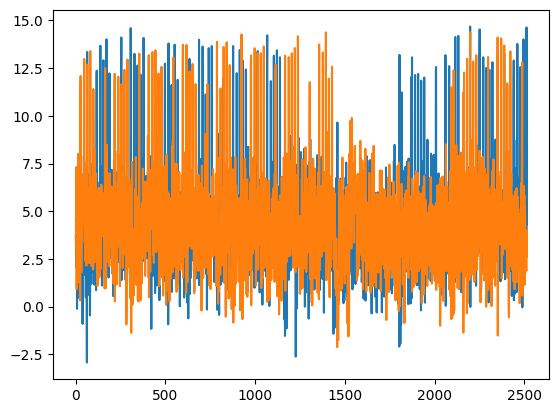

In [ ]:
for i in range(2):
  plt.plot(traces_sim_profiling[i])


In [ ]:
target_labels = labels_sim_profiling

In [ ]:
trace_length = traces_sim_profiling.shape[1]
mean = np.zeros([256, trace_length])
var = np.zeros([256, trace_length])
cpt = np.zeros(256)
i = 0

for trace in traces_sim_profiling:
  mean[target_labels[i]] += trace
  var[target_labels[i]] += np.square(trace)
  cpt[target_labels[i]] += 1
  i += 1

for i in range(256):
  if np.sum(np.abs(var[i]) < tolerance) > 0:
    var[i][np.abs(var[i]) < tolerance] = tolerance
  mean[i] = mean[i] / cpt[i]
  var[i]  = var[i] / cpt[i] - np.square(mean[i])

In [ ]:
varMean = np.var(mean,0)
meanVar = np.mean(var,0)

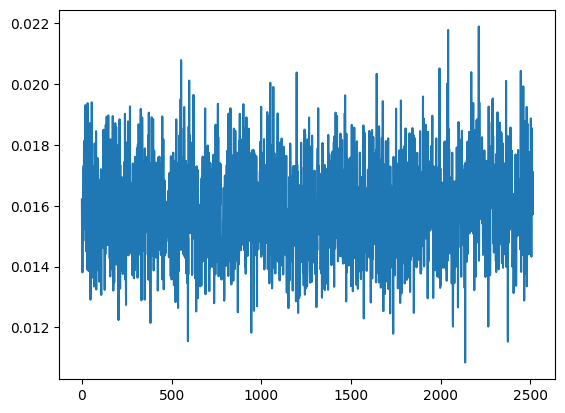

In [ ]:
# 'Desynced' plot
plt.plot(varMean/meanVar)

# Synced attempt

In [ ]:
npz_path_synced = '/content/drive/MyDrive/container_tracesdesynced_42.npz'

traces_sim_profiling, labels_sim_profiling = load_np_traces(npz_path_synced)

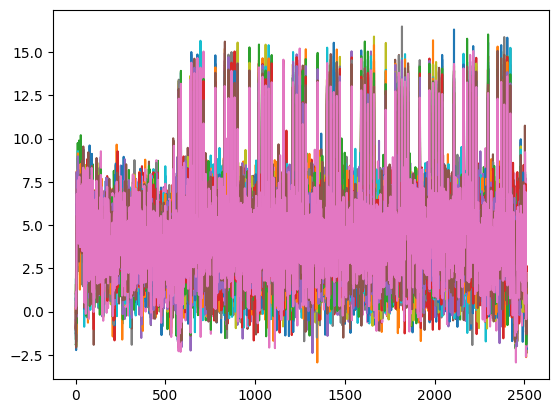

In [ ]:
for i in range(27):
  plt.plot(traces_sim_profiling[i])


In [ ]:
target_labels = labels_sim_profiling

In [ ]:
trace_length = traces_sim_profiling.shape[1]
mean = np.zeros([256, trace_length])
var = np.zeros([256, trace_length])
cpt = np.zeros(256)
i = 0

for trace in traces_sim_profiling:
  mean[target_labels[i]] += trace
  var[target_labels[i]] += np.square(trace)
  cpt[target_labels[i]] += 1
  i += 1

for i in range(256):
  if np.sum(np.abs(var[i]) < tolerance) > 0:
    var[i][np.abs(var[i]) < tolerance] = tolerance
  mean[i] = mean[i] / cpt[i]
  var[i]  = var[i] / cpt[i] - np.square(mean[i])

In [ ]:
varMean = np.var(mean,0)
meanVar = np.mean(var,0)

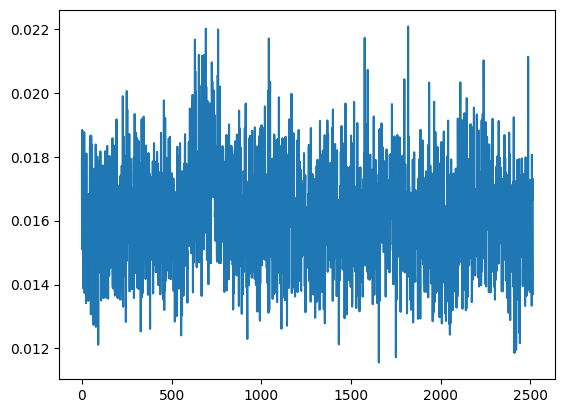

In [ ]:
# 'Desynced' plot
plt.plot(varMean/meanVar)

# Dell generated

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

npz_path = '/content/drive/MyDrive/container_traces_dell.npz'

def load_np_traces(traces_path):

  data = np.load(traces_path)

  traces=data["traces"]
  labels=data["labels"]

  return traces, labels

In [ ]:
traces_sim_profiling, labels_sim_profiling = load_np_traces(npz_path)

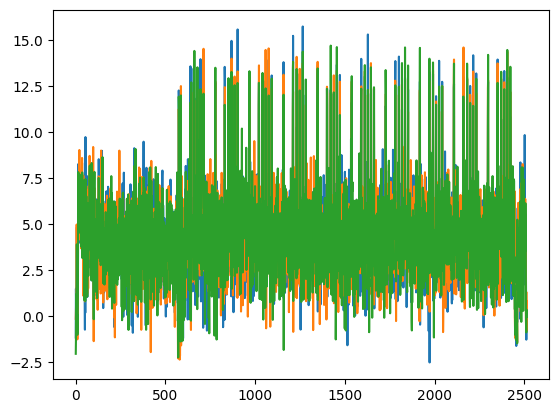

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
  plt.plot(traces_sim_profiling[i])

plt.show()

In [ ]:
t_labels = target_labels.reshape((5000, 16))

In [ ]:
t_labels.shape

(5000, 16)

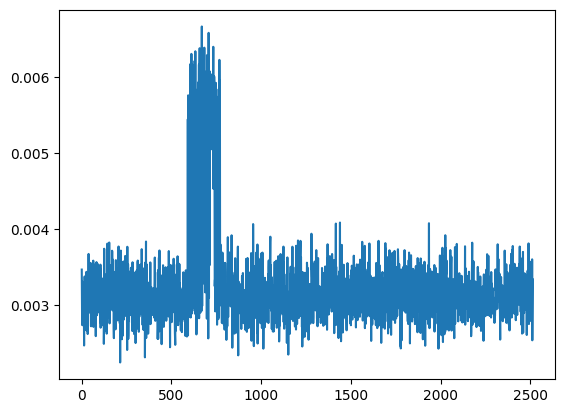

In [ ]:
target_labels = t_labels
tolerance = 1e-9

trace_length = traces_sim_profiling.shape[1]
mean = np.zeros([256, trace_length])
var = np.zeros([256, trace_length])
cpt = np.zeros(256)
i = 0

for trace in traces_sim_profiling:
  mean[target_labels[i]] += trace
  var[target_labels[i]] += np.square(trace)
  cpt[target_labels[i]] += 1
  i += 1

for i in range(256):
  if np.sum(np.abs(var[i]) < tolerance) > 0:
    var[i][np.abs(var[i]) < tolerance] = tolerance
  mean[i] = mean[i] / cpt[i]
  var[i]  = var[i] / cpt[i] - np.square(mean[i])

varMean = np.var(mean,0)
meanVar = np.mean(var,0)

plt.plot(varMean/meanVar)
plt.show()

# ASCAD baseline

In [ ]:
ascad_path = '/content/drive/MyDrive/ASCAD_databases/ATMega8515_raw_traces.h5'

n_samples = 10000
targeted_sbox_index = 2

f = h5py.File(ascad_path, "r")
l = f['traces'][:n_samples, :]

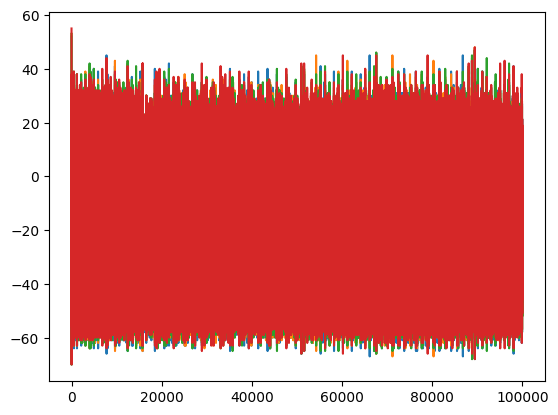

In [ ]:
for i in range(4):
  plt.plot(l[i])
plt.show()

In [ ]:
Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

HW = np.array([bin(n).count("1") for n in range(0,256)])

In [ ]:
l = l.astype(float)
data = np.array(f['metadata'][:n_samples])
k    = data['key'][:,targeted_sbox_index]
p    = data['plaintext'][:,targeted_sbox_index]
r    = data['masks'][:,targeted_sbox_index-2]
rout = data['masks'][:,15]

id_label_withMaskRout    = Sbox[k^p]^rout
hw_label_withMaskRout    = HW[id_label_withMaskRout]
id_label_withoutMaskRout = id_label_withMaskRout^rout
hw_label_withoutMaskRout = HW[id_label_withoutMaskRout]
id_label_withMaskR       = Sbox[k^p]^r

In [ ]:
hw_label_withMaskRout.shape

(10000,)

In [ ]:
trace_length = l.shape[1]
mean = np.zeros([256,trace_length])
var  = np.zeros([256,trace_length])
cpt  = np.zeros(256)
i = 0

for trace in l:
    mean[id_label_withoutMaskRout[i]]  += trace
    var [id_label_withoutMaskRout[i]]  += np.square(trace)
    cpt [id_label_withoutMaskRout[i]]  += 1
    i+=1

for i in range(256):
    mean[i] = mean[i] / cpt[i]
    var[i]  = var[i]  / cpt[i] - np.square(mean[i])

In [ ]:
varMean = np.var  (mean,0)
MeanVar = np.mean (var,0)

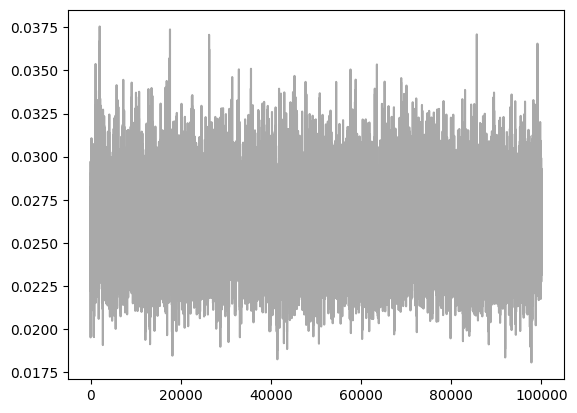

In [ ]:
plt.plot((varMean/MeanVar),'darkgray',label='snr1')

In [ ]:
my_snr_their_data = calculate_snr(l, id_label_withoutMaskRout)